<div style='text-align: center;'>
<img src="../images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Workbook - Week 5

# Tasks

1. Write code to generate Monte Carlo approximations to a European call option with parameters $S_0=94.68$, $T=1$, $X=100$, $r=0.05$, $q=0.02$ and $\sigma=0.4$.

In [1]:
import matplotlib.pyplot as plt
import numpy
rng = numpy.random.default_rng(seed=0) # create a random number generator and reset the starting value

In [2]:
S_0=94.68
T=1
X=100
r=0.05
q=0.02
sigma=0.4

In [3]:
n = 1000
ST = rng.lognormal(numpy.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*numpy.sqrt(T), n)
sum = 0.0
for i in range(0,n):
    sum += max(ST[i]-X,0.0)
value = sum/n *numpy.exp(-r*T)
print(" Call Option value:=",value)

 Call Option value:= 12.266180166032798


2. code up the Monte Carlo solver into a function

In [4]:
def monteCarloEuroCall(S_0,T,X,r,q,sigma,n):
    ST = rng.lognormal(numpy.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*numpy.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        sum += max(ST[i]-X,0.0)
    return sum/n *numpy.exp(-r*T)
    
print(" Call Option value:=",monteCarloEuroCall(S_0,T,X,r,q,sigma,n))

 Call Option value:= 13.977955356388719


3. run the function several times with the same value of $N$, what do the results look like?

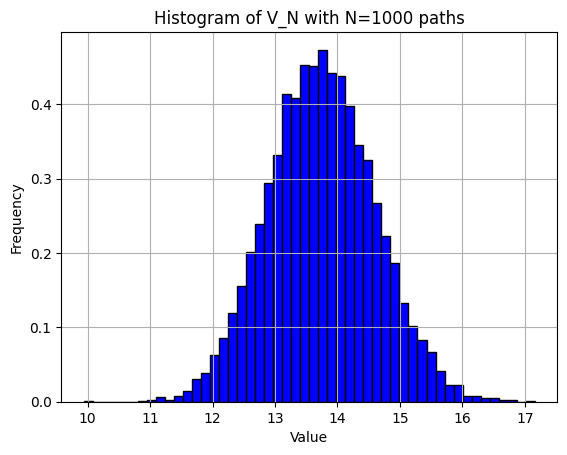

In [5]:
results = 10000
Varray = numpy.zeros(results)

for k in range(0,results):
    N=1000
    Varray[k] = monteCarloEuroCall(S_0,T,X,r,q,sigma,N)
    
plt.hist(Varray, bins=50, color='blue', edgecolor='black',density=True)
plt.title('Histogram of V_N with N=1000 paths')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Looks like we get a normal distribution as expected by the central limit theorem.

4. run the function for different values of $N=1000,2000,...$ and plot out the results, are they what you expected? Can you identify features of the graph?

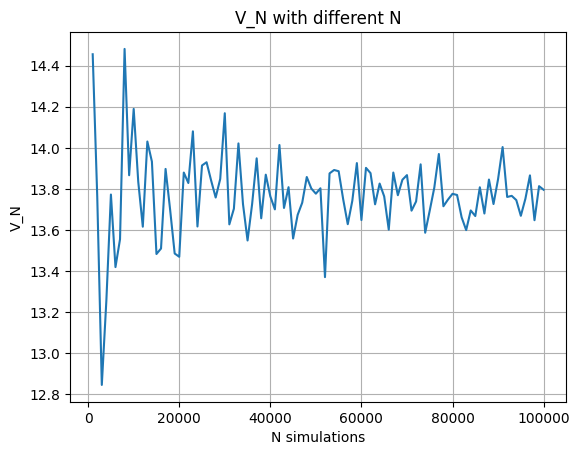

In [6]:
results = 100
Narray = numpy.zeros(results)
Varray = numpy.zeros(results)

for k in range(0,results):
    N=1000+k*1000
    Narray[k] = N
    Varray[k] = monteCarloEuroCall(S_0,T,X,r,q,sigma,N)
    
plt.plot(Narray,Varray)
plt.title('V_N with different N')
plt.xlabel('N simulations')
plt.ylabel('V_N')
plt.grid(True)
plt.show()

Again we can see that the mean of the distribution looks to be the same value for every value of $N$, and the variance of $V_N$ is going down as N increases. This is the result we expect to see according to the central limit theorem.

5. calculate the exact value of the call option using numerical integration or the analytic formula, to be denoted $V_\text{exact}$

Just for an example, let's calculate the value of the option using numerical integration. If we let $f(Y)$ denote the probability density of the risk neutral asset price $S_T$, then
$$
f(Y) = \frac{1}{\sigma Y\sqrt{2\pi T}} \exp\left( -\frac{\left(Y - \log(S_0)-(r-q-\frac12\sigma^2)T\right)^2}{2\sigma^2 T}  \right)
$$
and we need to calculate
$$
V(S_0,t=0) = e^{-rT} \int_X^\infty (Y-X) f(Y) dY
$$

In [7]:
from scipy.integrate import quad as QUAD

mean_logST , variance_logST = numpy.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*sigma*T

integrand = lambda Y: (Y - X) * numpy.exp(-((numpy.log(Y) - mean_logST)**2)/(2.*variance_logST)) / ( numpy.sqrt(2*numpy.pi*variance_logST) * Y )

I = QUAD(integrand , X, 15*X)
print(" V_exact:=",I[0]*numpy.exp(-r*T)," with error ",I[1])

 V_exact:= 13.764201624818366  with error  3.8255877351860926e-10


6. estimate the value of $\eta$ for the call option, and plot the lines $$V_\text{exact}\pm\frac{\eta}{\sqrt{n}}$$ does the picture look like you would expect?

First calculate $\eta$ inside the Monte Carlo function:

In [8]:
def monteCarloEuroCall_var(S_0,T,X,r,q,sigma,n):
    ST = rng.lognormal(numpy.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*numpy.sqrt(T), n)
    VT = numpy.zeros(n)
    for i in range(0,n):
        VT[i] = max(ST[i]-X,0.0)
    # return the value of the function and eta
    return numpy.average(VT) *numpy.exp(-r*T) , numpy.var(VT)

Then run the code for different values of $N$, and after calculating the exact value, plot three lines of the upper and lower bounds and the Monte Carlo result. Do you think the bounds look appropriate at the given confidence level?

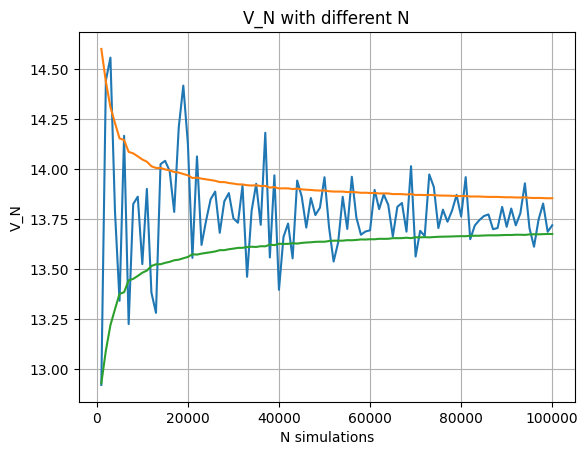

In [9]:
results = 100
Narray = numpy.zeros(results)
Varray = numpy.zeros(results)
Upperarray = numpy.zeros(results)
Lowerarray = numpy.zeros(results)

V_exact = I[0]*numpy.exp(-r*T)

for k in range(0,results):
    N=1000+k*1000
    Narray[k] = N
    Varray[k],eta = monteCarloEuroCall_var(S_0,T,X,r,q,sigma,N)
    Upperarray[k] = V_exact + numpy.sqrt(eta/N) 
    Lowerarray[k] = V_exact - numpy.sqrt(eta/N)

plt.plot(Narray,Varray)
plt.plot(Narray,Upperarray)
plt.plot(Narray,Lowerarray)
plt.title('V_N with different N')
plt.xlabel('N simulations')
plt.ylabel('V_N')
plt.grid(True)
plt.show()

7. try running the same analysis on a put option, a binary option or any other payoff. Are the results always the same?

Left as an exercise.

Following functions are required for the last part:

In [10]:
import numpy
rng = numpy.random.default_rng(seed=0) # create a random number generator and reset the starting value
def monteCarlov1(S_0,T,X,r,q,sigma,n,K):
    dt = T/K
    dW = rng.normal(0.0,numpy.sqrt(dt),size=(n,K))
    sum = 0.0
    for i in range(0,n):
        St=S_0
        for k in range(0,K):
            St=St + (r-q)*St*dt + sigma*St*dW[i][k]
        sum += max(St-X,0.0)
    return sum/n *numpy.exp(-r*T)
def monteCarlov2(S_0,T,X,r,q,sigma,n):
    WT = rng.normal(0.0,numpy.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        STi = S_0*numpy.exp((r-q-0.5*sigma*sigma)*T+sigma*WT[i])
        sum += max(STi-X,0.0)
    return sum/n *numpy.exp(-r*T)
def monteCarlov3(S_0,T,X,r,q,sigma,n):
    ST = rng.lognormal(numpy.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*numpy.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        sum += max(ST[i]-X,0.0)
    return sum/n *numpy.exp(-r*T)

8. Plot out the results of $V_n$ vs $n$ for each of the methods (you can choose $K=100$). Are the results converging on the correct value?

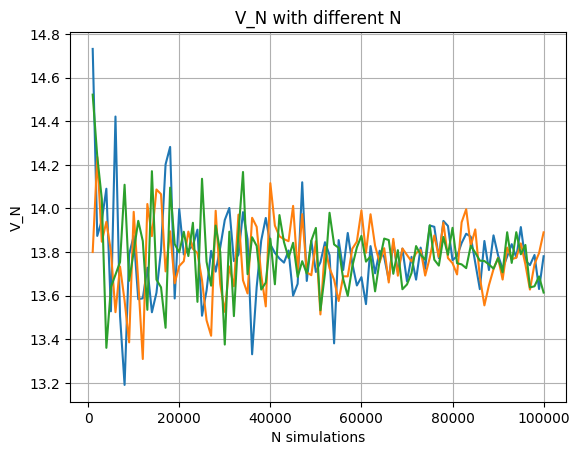

In [11]:
results = 100
Narray = numpy.zeros(results)
V1array = numpy.zeros(results)
V2array = numpy.zeros(results)
V3array = numpy.zeros(results)

for k in range(0,results):
    N=1000+k*1000
    Narray[k] = N
    V1array[k] = monteCarlov1(S_0,T,X,r,q,sigma,N,100)
    V2array[k] = monteCarlov2(S_0,T,X,r,q,sigma,N)
    V3array[k] = monteCarlov3(S_0,T,X,r,q,sigma,N)


plt.plot(Narray,V1array)
plt.plot(Narray,V2array)
plt.plot(Narray,V3array)
plt.title('V_N with different N')
plt.xlabel('N simulations')
plt.ylabel('V_N')
plt.grid(True)
plt.show()


9. Can you generate a confidence interval for a result with $n=1000000$ paths?

For 1,000,000 paths, we could do 1000 runs of $V_{1000}$ and take the average, and then use the variance of those results to create a confidence interval.

In [17]:
results = 1000

# create an array to store the results
Varray = numpy.zeros(results)

for k in range(0,results):
    Varray[k] = monteCarlov3(S_0,T,X,r,q,sigma,n)
    
mean_V1000 = numpy.average(Varray)
var_V1000 = numpy.var(Varray)
print(" Our estimate with 1,000,000 simulations is V_1000000:=",mean_V1000)
print(" Standard error for this result is:=",numpy.sqrt(var_V1000/1000))
print(" Therefore we are 95% confident the result is in the interval [",mean_V1000-1.96*numpy.sqrt(var_V1000/1000)," , ",mean_V1000+1.96*numpy.sqrt(var_V1000/1000),"]")

 Our estimate with 1,000,000 simulations is V_1000000:= 13.822440432160327
 Standard error for this result is:= 0.026809572445787282
 Therefore we are 95% confident the result is in the interval [ 13.769893670166585  ,  13.87498719415407 ]


We know that the exact result is well within the limits of this interval.

10. Run the code timings below -- can you explain why some codes take longer than others?

In [18]:
from timeit import timeit
n = 10000
K = 100
S_0=94.68
T=1
X=100
r=0.05
q=0.02
sigma=0.4

script="monteCarlov1(S_0,T,X,r,q,sigma,n,K)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )

print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")
script="monteCarlov2(S_0,T,X,r,q,sigma,n)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )

print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")
script="monteCarlov3(S_0,T,X,r,q,sigma,n)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )

print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

Time taken to run  100  simulations with  10000  paths is 56.192305953998584  seconds.
Time taken to run  100  simulations with  10000  paths is 1.4184108730005391  seconds.
Time taken to run  100  simulations with  10000  paths is 0.3757632829983777  seconds.


Is it obvious that "v1" has 100 times as many calculations as the other two, so we can easily imagine why that is so much slower. For the difference between "v2" and "v3", this is more to do with Python coding, and the way your code is executed. In both cases the number of calculations is broadly the same, but in "v2" you work out $\ln(S_0) + (r-q-\frac12\sigma^2)$ for every path, whereas in "v3" you only do this calculation once. In programming languages such as c++ the compiler will often notice this for you and automatically change your code so that it is only calculated once. The result would be "v2" and "v3" have almost identical run times. Obviously you need to be very careful when coding in python otherwise certain algorithms or modifications won't work as advertised.

11. Can you improve the run times using `numba` or `cython`?

Left as an exercise.